# BigDL object detection demo

In [30]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Disable auto scroll

In [31]:
from bigdl.util.common import *
init_engine()

Verify and read some environment information (e.g. executor number and executor core number)

In [32]:
# load object class names
with open("../../pipeline/ssd/data/pascal/classname.txt") as f:
    classes = f.read().splitlines()

print classes
print 'In total ', len(classes), 'classes'

['__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
In total  21 classes


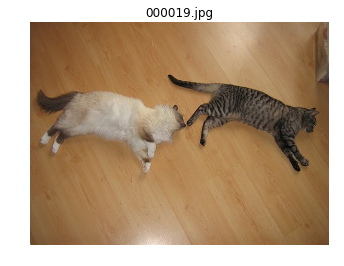

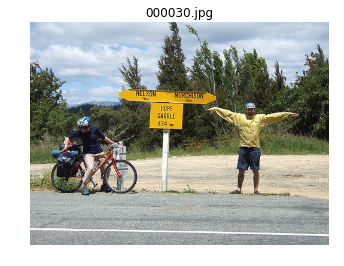

In [33]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
# load and show images
folder = "../../pipeline/ssd/data/pascal/images"
imageFiles = os.listdir(folder)
images = []
for f in imageFiles:
    image = cv2.imread(folder + '/' + f)
    images.append(image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f)
    plt.show()

img_rdd = sc.parallelize(images)

In [34]:
from bigdl.nn.layer import Model
# load model
model = Model.load("/home/jxy/code/analytics-zoo/pipeline/ssd/data/models/bigdl_mobilenet.model")
print 'load model done'

load model done


In [35]:
from scipy import misc

# data preprocess
def preprocess(img_rdd, means, scale, resolution):

    sizes = img_rdd.map(lambda img: img.shape)

    data =  img_rdd.map(lambda original_img: misc.imresize(original_img, (resolution, resolution))) \
    .map(lambda resized_img: (resized_img[:, :] - means) * scale) \
    .map(lambda normalized_img: normalized_img.transpose(2, 0, 1)) \
    .map(lambda normalized_img: Sample.from_ndarray(normalized_img, np.array([-1])))
    return (data, sizes)

In [36]:
def scaleOutput(output, img_size):
    total = int(output[0])
    detections = output[1:total*6 + 1].reshape(total, 6)
    height = img_size[0]
    width = img_size[1]
    # scale from (0, 1) to original image size
    detections[:, 2] *= width
    detections[:, 3] *= height
    detections[:, 4] *= width
    detections[:, 5] *= height
    return detections


In [37]:
def visualize(img, detections, threshold = 0.6):
    total = detections.shape[0]
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    for i in range(0, total):
        score = detections[i][1]
        cls_id = int(detections[i][0])
        if (score <= threshold):
            continue
        cv2.rectangle(img,(detections[i][2],detections[i][3]),(detections[i][4],detections[i][5]),(0,255,0),3)
        cv2.putText(img,'{:s} {:.3f}'.format(classes[cls_id], score),
                    (int(detections[i][2]),int(detections[i][3] - 2)), font, 1,(255,255,255),1,cv2.LINE_AA)
    return img

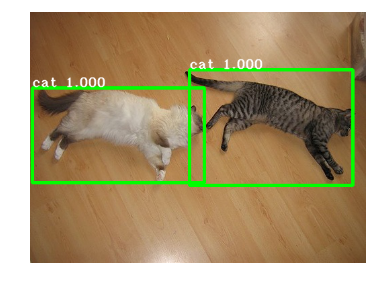

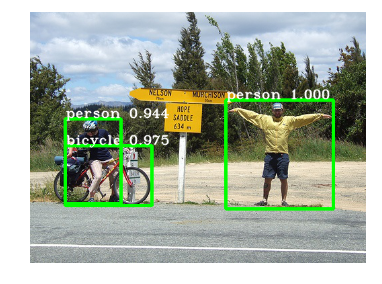

In [39]:
means = np.array([127.5, 127.5, 127.5]) # mean value in BGR order
scale = 0.007843
resolution = 300
(data, sizes) = preprocess(img_rdd, means, scale, resolution)

output = model.predict(data)

result = output.zip(sizes).map(lambda (output_i, img_size):
    scaleOutput(output_i, img_size)
 ).collect()

for img_id in range(len(result)):
    detections = result[img_id]
    visualize(images[img_id], detections)
    plt.subplots(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(images[img_id], cv2.COLOR_BGR2RGB))
    plt.axis('off')
    

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import *
from IPython.display import HTML
myclip = VideoFileClip("/home/jxy/Downloads/Dog imitates baby.mp4").subclip(139,149)

video_rdd = sc.parallelize(myclip.iter_frames(fps=5))
(data, sizes) = preprocess(video_rdd, means, scale, resolution)

output = model.predict(data)

detection = output.zip(sizes).map(lambda (output_i, img_size): scaleOutput(output_i, img_size))


In [43]:
image_detection = video_rdd.zip(detection).map(lambda (data, result): visualize(data, result, 0.3))
results = image_detection.collect()
results = filter(lambda x: x!=None, results)



In [26]:
clip = ImageSequenceClip(results, fps=5)

output_path = '/tmp/out.mp4'
%time clip.write_videofile(output_path, audio=False)

import io
import base64
from IPython.display import HTML

video = io.open(output_path, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


[MoviePy] >>>> Building video /tmp/out.mp4
[MoviePy] Writing video /tmp/out.mp4


100%|██████████| 50/50 [00:00<00:00, 121.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /tmp/out.mp4 

CPU times: user 48 ms, sys: 44 ms, total: 92 ms
Wall time: 1.35 s


In [22]:
from moviepy.editor import *
clip = VideoFileClip(output_path)
clip.write_gif("/tmp/final.gif")


[MoviePy] Building file /tmp/final.gif with imageio


 98%|█████████▊| 50/51 [00:09<00:00,  4.69it/s]
